# Thesis ABM model

Network model between agents that creates stochastic payment shocks then settles payments. Agents are affliliated to a bank. If with the same bank, settlement occurs in period. If with different bank, payment occurs every fourth period due to "batching".

## Configuring the model

In the Black Rhino framework, parameters are stored in xml files. Using this notebook, you can set change them. First, you need to import the elementree from the xml Python module.

In [81]:
import xml.etree.ElementTree as ET

Below you will find the parameter inputs for this model. Change the parameter values for different configurations of the model.

In [82]:
parameter_values = (('num_sweeps', '2'),
                    ('num_simulations', '1'),
                    ('num_households', '2'),
                    ('num_firms', '1'),
                    ('num_banks', '1'),
                    ('batch', '1'),
                    ('household_directory', 'agents/gen_households/'),
                    ('firm_directory', 'agents/gen_firms/'),
                    ('bank_directory', 'agents/gen_banks/'),
                    ('central_bank_directory', 'agents/central_bank/'),
                    ('measurement_config', 'measurements/test_output.xml')
                   )

To translate this to an xml document, which the framework can read, we first need create an ET element. 

In [83]:
environment = ET.Element('environment', identifier = "CBDC_parameters")

And create parameter elements and give them the values seen below to add to the tree object.

In [84]:
parameters = []
for x in range(len(parameter_values)):
    parameters.append(ET.SubElement(environment, 'parameter'))
    
for idx, p in enumerate(parameters):
    p.set('type', 'static')
    p.set('name', parameter_values[idx][0])
    p.set('value', parameter_values[idx][1])

This object can now be transformed to a string and written to an xml file using the code below. 

In [85]:
xml_params = ET.tostring(environment, encoding="UTF-8")
myfile = open("environments/CBDC_parameters.xml", "w")
xml_params = "<?xml version='1.0' encoding='UTF-8'?>\n" + str(xml_params, encoding = "UTF-8")
myfile.write(xml_params)
myfile.close()

Now, the parameter xml file has been generated and the model can be run. Before, running the model, you need to import a couple of extra modules. These are the Python logging module, the Black Rhino environment class, and the Black Rhino runner class.

In [86]:
import logging
import os
from src.environment import Environment
from src.runner import Runner

Then, before running the model, the logger needs to be initialized.

In [87]:
log_directory = "log/"
identifier = "/CBDC_parameters"
environment_directory = "environments/"
if not os.path.exists('log'):
    os.makedirs('log')
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    filename=log_directory + identifier + ".log", level=logging.INFO)
logging.info('START logging for run: %s',  environment_directory + identifier + ".xml")

Generate banks and households using the generate agents class. First remove any agents still in directories. Then generate agents, the number of households and banks needs to be specified. In the generate banks method, the number of banks is the second argument. In the generate households method, the number of households it the second argument and the number of banks is the thrid argument.

In [88]:
import os
remove = True

bank_dir = os.getcwd()+'/agents/gen_banks/'
house_dir = os.getcwd()+'/agents/gen_households/'
firm_dir = os.getcwd()+'/agents/gen_firms/'
if remove:
    bank_list = [ f for f in os.listdir(bank_dir) if f.startswith("bank") ]
    house_list = [ f for f in os.listdir(house_dir) if f.startswith("house") ]
    firm_list = [ f for f in os.listdir(firm_dir) if f.startswith("firm") ]
for f in bank_list:
    os.remove(os.path.join(bank_dir, f))
for f in house_list:
    os.remove(os.path.join(house_dir, f))
for f in firm_list:
    os.remove(os.path.join(firm_dir, f))

In [89]:
from src.br_generate_agents import Generate_Agents
gen_agents = Generate_Agents()

gen_agents.generate_households(parameter_values[2][1], "./agents/gen_households/")

gen_agents.generate_firms(parameter_values[3][1], "./agents/gen_firms/")

gen_agents.generate_banks(parameter_values[4][1], "./agents/gen_banks/")

First, the environment will be initialized. It contains the model parameters and variables. The environment also contains a list of agents. In the Solow model, the environment contains one bank, one firm, and one household. Finally, it also contains initialized transactions for these agents.

In [90]:
environment = Environment(environment_directory, identifier)

Next up, the runner object is created. As the name suggests, the runner object handles the running of the model. But that is not all, it also initializes the updater.

In [91]:
runner = Runner(environment)

Now you can actually run the model. Since the agent-based model is simulated using Monte Carlo methods. This means that the model will be run multiple times (num_simulations). For every simulation run, the environment and runner will be (re-)initialized. Then, the runner will run the Solow model. During the run, the runner will write data about capital to a csv file specified within the Measurement class and print out all the transactions happening and the books of firm and household at the end of each sweep.

In [92]:
for i in range(int(environment.num_simulations)):
    logging.info('  STARTED with run %s',  str(i))
    environment.initialize(environment_directory,  identifier)
    runner.initialize(environment)
    
    runner.do_run(environment)
    logging.info('  DONE')

measurements/test_output.xml
household_1 took out loan of 20.0 at bank_0 
household_0 took out loan of 20.0 at bank_0 
firm_0 took out loan of 30.0 at bank_0 
bank_0 has 14.0 reserves, and 14.0 Open Market Operations
CBDC settlement of 10.0 to household_1 complete
Bank Notes settlement of 5.0 to household_1 complete
household_1 chose 5.0 deposits, 10.0 cbdc, and 5.0 bank_notes
CBDC settlement of 10.0 to household_0 complete
Bank Notes settlement of 5.0 to household_0 complete
household_0 chose 5.0 deposits, 10.0 cbdc, and 5.0 bank_notes
CBDC settlement of 10.0 to firm_0 complete
Bank Notes settlement of 0.0 to firm_0 complete
firm_0 chose 20.0 deposits, 10.0 cbdc, and 0.0 bank_notes
measurements/test_output.xml
household_1 provided firm_0 with 100.0 units of labour
household_0 provided firm_0 with 100.0 units of labour
firm_0 took out new loan of 200.0 at bank_0
bank_0 required more reserves, since 14.0 reserves is less than 200.0 loan amount
firm_0s paid 100.0 to bank_0 for household_

In [93]:
import pandas as pd
thesis_data = pd.read_csv('measurements/TestMeasurement.csv', index_col=0) 

In [94]:
print(thesis_data.head(3))
print(thesis_data.tail(4))

      Deposit Balance   B_0  B_1  B_2  B_3  B_4  Total_Payments  CBDC Balance  \
Step                                                                            
1                10.0  30.0  NaN  NaN  NaN  NaN               0          20.0   
2                10.0  30.0  NaN  NaN  NaN  NaN               0          20.0   

      Batch Balance  CBDC_Payments  Deposits_Payments  Total_Output  
Step                                                                 
1                 0              0                  0           0.0  
2                 0              0                  0         200.0  
      Deposit Balance   B_0  B_1  B_2  B_3  B_4  Total_Payments  CBDC Balance  \
Step                                                                            
1                10.0  30.0  NaN  NaN  NaN  NaN               0          20.0   
2                10.0  30.0  NaN  NaN  NaN  NaN               0          20.0   

      Batch Balance  CBDC_Payments  Deposits_Payments  Total_Output  


Check consistency of Households, Banks and Central Bank

In [95]:
house = True
for houses in environment.banks:
    house *= houses.check_consistency()
if house:
    print("True")
else:
    print("False")

firm = True
for firms in environment.firms:
    firm *= firms.check_consistency()
if firm:
    print("True")
else:
    print("False")

bank = True
for banks in environment.banks:
    bank *= banks.check_consistency()
if bank:
    print("True")
else:
    print("False")


print(environment.central_bank[0].check_consistency())

True
True
True
True


In [96]:
import matplotlib.pyplot as plt

/var/folders/nx/sfr0g06x255301jlc_nyn7c00000gn/T/ipykernel_25819/1081937997.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ax.plot(thesis_data.index, thesis_data.drop(["Total_Payments", "CBDC Balance", "Batch Balance", "CBDC_Payments", "Deposits_Payments", "Total_Output"], 1))


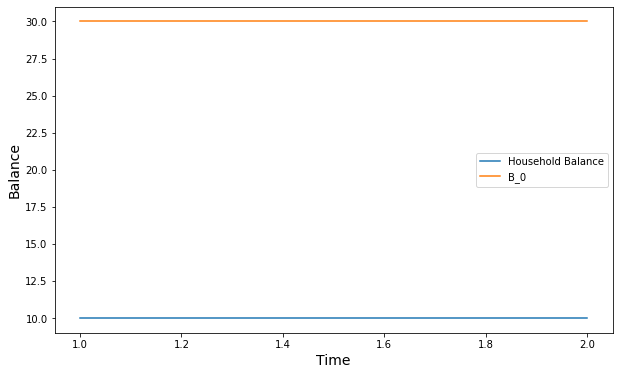

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

ax.plot(thesis_data.index, thesis_data.drop(["Total_Payments", "CBDC Balance", "Batch Balance", "CBDC_Payments", "Deposits_Payments", "Total_Output"], 1))
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['Household Balance', 'B_0'])#, 'B_1']) #, 'B_2', 'B_3', 'B_4'])

fig.savefig('deposit_balances.png')

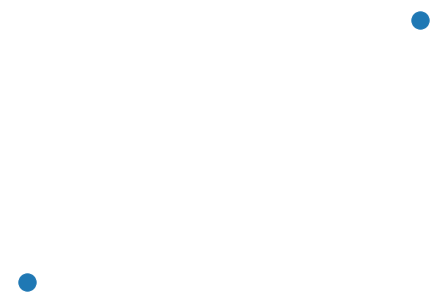

In [98]:
import networkx as nx
nx.draw_shell(environment.social_network)

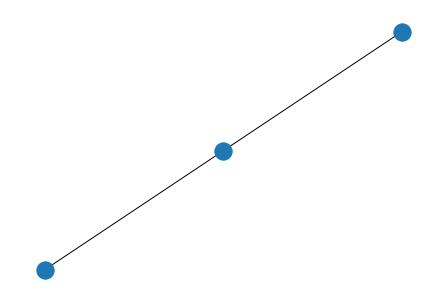

In [99]:
import networkx as nx
nx.draw(environment.employment_network)

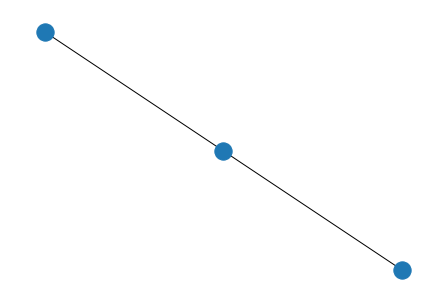

In [100]:
import networkx as nx
nx.draw(environment.consumption_network)

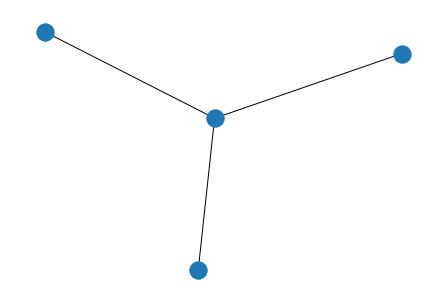

In [101]:
import networkx as nx
nx.draw(environment.bank_network)